# Algorytmy geometryczne

# Projekt: Otoczka wypukła dla zbioru punktów w przestrzeni dwuwymiarowej 

## Michał Kuszewski, Adam Naumiec

## Grupa 4 – czwartek, 11:20-12:50, tydzień B

## Algorytmy:
1. Dziel i rządź 
2. Przyrostowy
3. Quickhull
4. Górnej i dolnej otoczki
5. Jarvisa
6. Grahama
7. Chana

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Zbiory losowo wygenerowanych punktów

### Testowe zbiory punktów

#### Parametry zbiorów testowych

In [3]:
EPSILON = 10 ** -12

A_NUM = 100
A_MIN_RNG = -100
A_MAX_RNG = 100

B_NUM = 100
B_RADIUS = 10
B_CENTER = (0, 0)

C_NUM = 100
C_V_1 = (-10, 10)
C_V_2 = (-10, -10)
C_V_3 = (10, -10)
C_V_4 = (10, 10)

D_NUM_SIDE = 25
D_NUM_DIAGONAL = 20
D_V_1 = (0, 0)
D_V_2 = (10, 0)
D_V_3 = (10, 10)
D_V_4 = (0, 10)

#### Zbiór A

In [4]:
from random import uniform

def gen_set_a(A_NUM=100, A_MIN_RNG=-100, A_MAX_RNG=100):
    set_a = [(uniform(A_MIN_RNG, A_MAX_RNG), uniform(A_MIN_RNG, A_MAX_RNG)) for _ in range(A_NUM)]
    
    return set_a

#### Zbiór B

In [5]:
from math import pi, sin, cos
from random import uniform

def gen_set_b(B_NUM=100, B_RADIUS=10, B_CENTER=(0,0)):
    set_b = []

    for _ in range(B_NUM):
        t = uniform(0, 2 * pi)
        x = B_RADIUS * sin(t) + B_CENTER[0]
        y = B_RADIUS * cos(t) + B_CENTER[1]

        set_b.append((x, y))
    
    return set_b

#### Zbiór C

In [6]:
from random import choice, uniform

corners_c = [C_V_1, C_V_2, C_V_3, C_V_4]

def gen_set_c(C_NUM=100,
              C_V_1=(-10,10), C_V_2=(-10,-10), C_V_3=(10,-10), C_V_4=(10,10)):
    set_c = [C_V_1, C_V_2, C_V_3, C_V_4]

    for _ in range(C_NUM):
        side = choice((1,2,3,4))

        if side == 1:
            x = uniform(C_V_1[0], C_V_2[0])
            y = uniform(C_V_1[1], C_V_2[1])
        elif side == 2:
            x = uniform(C_V_2[0], C_V_3[0])
            y = uniform(C_V_2[1], C_V_3[1])
        elif side == 3:
            x = uniform(C_V_3[0], C_V_4[0])
            y = uniform(C_V_3[1], C_V_4[1])
        elif side == 4:
            x = uniform(C_V_4[0], C_V_1[0])
            y = uniform(C_V_4[1], C_V_1[1])

        set_c.append((x, y))
        
    return set_c

#### Zbiór D

In [7]:
from random import uniform

corners_d = [D_V_1, D_V_2, D_V_3, D_V_4]

def gen_set_d(D_NUM_SIDE=25,
              D_NUM_DIAGONAL=20,
              D_V_1=(0,0), D_V_2=(10,0), D_V_3=(10,10), D_V_4=(0,10)):
    set_d = [D_V_1, D_V_2, D_V_3, D_V_4]

    for _ in range(D_NUM_SIDE):
        x = uniform(D_V_1[0], D_V_2[0])
        y = D_V_1[1]
        set_d.append((x, y))

    for _ in range(D_NUM_SIDE):
        x = D_V_1[0]
        y = uniform(D_V_1[1], D_V_4[1])
        set_d.append((x, y))

    for _ in range(D_NUM_DIAGONAL):
        x = uniform(D_V_1[0], D_V_2[0])
        y = x + D_V_1[1]
        set_d.append((x, y))

    for _ in range(D_NUM_DIAGONAL):
        x = uniform(D_V_1[0], D_V_2[0])
        y = -x + D_V_3[1]
        set_d.append((x, y))
        
    return set_d

In [8]:
set_a = gen_set_a()
set_b = gen_set_b()
set_c = gen_set_c()
set_d = gen_set_d()

### Generowanie zbiorów punktów

In [9]:
import random

def generate_points(amount, min_x, max_x, min_y, max_y):
    points = []
    
    for _ in range(amount):
        points.append((random.uniform(min_x, max_x), random.uniform(min_y, max_y)))
    
    return points

## Funkcje pomocnicze

In [10]:
def det(a, b, c):
    result = (a[0] - c[0]) * (b[1] - c[1]) - (b[0] - c[0]) * (a[1] - c[1])

    if abs(result) <= 10**(-12): #Collinear
        return 0
    elif result > 0: #Counterclockwise
        return 1
    else: #Clockwise
        return -1

In [11]:
def distance(a, b):
    return ((a[0] - b[0])**2 + (a[1] - b[1])**2 )**0.5

In [12]:
import time

def measure_time(function, points):
    start = time.time()
    function(points)
    stop = time.time()
    
    return round(stop - start, 3)

In [13]:
def are_collinear(points):
    n = len(points)
    
    if n < 3:
        return True
    
    for i in range(n):
        if det(points[i], points[(i + 1) % n], points[(i + 2) % n]) != 0:
            return False
    
    return True

# Dziel i rządź

In [14]:
def brute_convex_hull(points):
    n = len(points)
    
    hull = []
    
    for i in points:
        for j in points:
            if i == j:
                continue
            
            on_left = 0
            
            for k in points:
                if i == k or j == k:
                    continue
                
                d = det(i, j, k)
                
                if d > 0:
                    on_left += 1
                elif d == 0:
                    if distance(i, j) > distance(i, k):
                        on_left +=1
            
            
            if on_left == n - 2:
                hull.append((i, j))
    
    a, b = hull[0]
    result = []
    
    while True:
        result.append(a)
        
        if b == result[0]:
            break
        
        for i in range(len(hull)):
            if b == hull[i][0]:
                a = b
                b = hull[i][1]
                break
    
    return result

In [15]:
def convex_hull(points):
    n = len(points)
    
    if n <= 5:
        return brute_convex_hull(points)
    
    left = []
    right = []
    
    for i in range(n//2):
        left.append(points[i])
    for i in range(n//2, n):
        right.append(points[i])
    
    left_convex_hull = convex_hull(left)
    right_convex_hull = convex_hull(right)
    
    return merge(left_convex_hull, right_convex_hull)

In [16]:
def find_leftmost(points):
    index = 0
    
    for i in range(len(points)):
        if points[i] < points[index]:
            index = i
    
    return index

In [17]:
def find_rightmost(points):
    index = 0
    
    for i in range(len(points)):
        if points[i] > points[index]:
            index = i
    
    return index

In [18]:
def merge(left, right):
    n1 = len(left)
    n2 = len(right)
    
    is_left_collinear = are_collinear(left)
    is_right_collinear = are_collinear(right)
    are_both_collinear = are_collinear(left + right)
    
    if are_both_collinear:
        top_left = bottom_left = find_leftmost(left)
        top_right = bottom_right = find_rightmost(right)
    elif is_left_collinear:
        left_index = top_left = bottom_left = find_leftmost(left)
        leftmost = find_leftmost(right)
        right_index = leftmost
        
        while det(left[left_index], right[right_index], right[(n2 + right_index - 1) % n2]) >= 0:
            right_index = (n2 + right_index - 1) % n2
        
        top_right = right_index
    
        right_index = leftmost
        
        while det(left[left_index], right[right_index], right[(right_index + 1) % n2]) <= 0:
            right_index = (right_index + 1) % n2
        
        bottom_right = right_index
    elif is_right_collinear:
        right_index = top_right = bottom_right = find_rightmost(right)
        rightmost = find_rightmost(left)
        left_index = rightmost
        
        while det(right[right_index], left[left_index], left[(left_index + 1) % n1]) <= 0:
            left_index = (left_index + 1) % n1
        
        top_left = left_index
        
        left_index = rightmost
        
        while det(right[right_index], left[left_index], left[(n1 + left_index - 1) % n1]) >= 0:
            left_index = (n1 + left_index - 1) % n1
        
        bottom_left = left_index
    else:
        rightmost = find_rightmost(left)
        leftmost = find_leftmost(right)

        left_index = rightmost
        right_index = leftmost

        cond = True

        while cond:
            cond = False

            while det(right[right_index], left[left_index], left[(left_index + 1) % n1]) <= 0:
                left_index = (left_index + 1) % n1

            while det(left[left_index], right[right_index], right[(n2 + right_index - 1) % n2]) >= 0:
                right_index = (n2 + right_index - 1) % n2
                cond = True

        top_left = left_index
        top_right = right_index


        left_index = rightmost
        right_index = leftmost

        cond = True

        while cond:
            cond = False

            while det(left[left_index], right[right_index], right[(right_index + 1) % n2]) <= 0:
                right_index = (right_index + 1) % n2

            while det(right[right_index], left[left_index], left[(n1 + left_index - 1) % n1]) >= 0:
                left_index = (n1 + left_index - 1) % n1
                cond = True

        bottom_left = left_index
        bottom_right = right_index
    
    hull = [left[top_left]]
    
    i = top_left
    while i != bottom_left:
        i = (i + 1) % n1
        hull.append(left[i])
    
    i = bottom_right
    hull.append(right[bottom_right])
    while i != top_right:
        i = (i + 1) % n2
        hull.append(right[i])
    
    return hull

In [19]:
def divide_and_conquer(points):
    n = len(points)
    
    if len(points) < 3:
        return None
    
    indexes = {}
    
    for i in range(n):
        indexes[points[i]] = i
    
    points = list(points)
    
    points.sort()
    
    convex = convex_hull(points)
    
    result = [indexes[convex[i]] for i in range(len(convex))]
    
    return result

In [20]:
def divide_and_conquer_visualisation(points):
    if len(points) < 3:
        return None
    
    points = list(points)
    
    points.sort()
    scenes = []
    
    result = convex_hull_visualisation(points, points, scenes)
    
    scenes.append(
        Scene(points=[PointsCollection(points, color="blue"), PointsCollection(result, color="red")]
    ))
    
    return scenes

In [21]:
def convex_hull_visualisation(points, all_points, scenes):
    n = len(points)
    
    if n <= 5:
        return brute_convex_hull(points)
    
    left = []
    right = []
    
    for i in range(n//2):
        left.append(points[i])
    for i in range(n//2, n):
        right.append(points[i])
    
    left_convex_hull = convex_hull_visualisation(left, all_points, scenes)
    right_convex_hull = convex_hull_visualisation(right, all_points, scenes)
    
    return merge_visualisation(left_convex_hull, right_convex_hull, all_points, scenes)

In [22]:
def brute_convex_hull(points):
    n = len(points)
    
    hull = []
    
    for i in points:
        for j in points:
            if i == j:
                continue
            
            on_left = 0
            
            for k in points:
                if i == k or j == k:
                    continue
                
                d = det(i, j, k)
                
                if d > 0:
                    on_left += 1
                elif d == 0:
                    if distance(i, j) > distance(i, k):
                        on_left +=1
            
            if on_left == n - 2:
                hull.append((i, j))
    
    a, b = hull[0]
    result = []
    
    while True:
        result.append(a)
        
        if b == result[0]:
            break
        
        for i in range(len(hull)):
            if b == hull[i][0]:
                a = b
                b = hull[i][1]
                break
    
    return result

In [23]:
def convert_points_to_lines(points):
    n = len(points)
    
    lines = []
    
    for i in range(n):
        lines.append([points[i], points[(i+1) % n]])
    
    return lines

In [24]:
def merge_visualisation(left, right, all_points, scenes):
    left_visualisation = convert_points_to_lines(left)
    right_visualisation = convert_points_to_lines(right)
    
    scenes.append(
        Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
              lines = [LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow")]
    ))
    
    n1 = len(left)
    n2 = len(right)
    
    is_left_collinear = are_collinear(left)
    is_right_collinear = are_collinear(right)
    are_both_collinear = are_collinear(left + right)
    
    if are_both_collinear:
        top_left = bottom_left = find_leftmost(left)
        top_right = bottom_right = find_rightmost(right)
        
        scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow"), LinesCollection([[left[top_left], right[top_right]], [left[bottom_left], right[bottom_right]]], color="orange")]
                ))
        
    elif is_left_collinear:
        left_index = top_left = bottom_left = find_leftmost(left)
        leftmost = find_leftmost(right)
        right_index = leftmost
        
        while det(left[left_index], right[right_index], right[(n2 + right_index - 1) % n2]) >= 0:
            scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [left[left_index], right[right_index]],
                        [right[right_index], right[(n2 + right_index - 1) % n2]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow")]
                ))
            
            right_index = (n2 + right_index - 1) % n2
        
        top_right = right_index
    
        right_index = leftmost
        
        while det(left[left_index], right[right_index], right[(right_index + 1) % n2]) <= 0:
            scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [left[left_index], right[right_index]],
                        [right[right_index], right[(right_index + 1) % n2]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow"), LinesCollection([[left[top_left], right[top_right]]], color="orange")]
                ))
            
            right_index = (right_index + 1) % n2
        
        bottom_right = right_index
    elif is_right_collinear:
        right_index = top_right = bottom_right = find_rightmost(right)
        rightmost = find_rightmost(left)
        left_index = rightmost
        
        while det(right[right_index], left[left_index], left[(left_index + 1) % n1]) <= 0:
            scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [right[right_index], left[left_index]],
                        [left[left_index], left[(left_index + 1) % n1]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow")]
                ))
            
            left_index = (left_index + 1) % n1
        
        top_left = left_index
        
        left_index = rightmost
        
        while det(right[right_index], left[left_index], left[(n1 + left_index - 1) % n1]) >= 0:
            scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [right[right_index], left[left_index]],
                        [left[left_index], left[(n1 + left_index - 1) % n1]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow"), LinesCollection([[left[top_left], right[top_right]]], color="orange")]
                ))
            
            left_index = (n1 + left_index - 1) % n1
        
        bottom_left = left_index
    else:
        rightmost = find_rightmost(left)
        leftmost = find_leftmost(right)

        left_index = rightmost
        right_index = leftmost

        cond = True

        while cond:
            cond = False

            while det(right[right_index], left[left_index], left[(left_index + 1) % n1]) <= 0:
                scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [right[right_index], left[left_index]],
                        [left[left_index], left[(left_index + 1) % n1]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow")]
                ))
                left_index = (left_index + 1) % n1

            while det(left[left_index], right[right_index], right[(n2 + right_index - 1) % n2]) >= 0:
                scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [left[left_index], right[right_index]],
                        [right[right_index], right[(n2 + right_index - 1) % n2]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow")]
                ))
                right_index = (n2 + right_index - 1) % n2
                cond = True

        top_left = left_index
        top_right = right_index


        left_index = rightmost
        right_index = leftmost

        cond = True

        while cond:
            cond = False

            while det(left[left_index], right[right_index], right[(right_index + 1) % n2]) <= 0:
                scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [left[left_index], right[right_index]],
                        [right[right_index], right[(right_index + 1) % n2]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow"), LinesCollection([[left[top_left], right[top_right]]], color="orange")]
                ))
                right_index = (right_index + 1) % n2

            while det(right[right_index], left[left_index], left[(n1 + left_index - 1) % n1]) >= 0:
                scenes.append(
                    Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(left, color="red"), PointsCollection(right, color="yellow")],
                    lines=[LinesCollection([
                        [right[right_index], left[left_index]],
                        [left[left_index], left[(n1 + left_index - 1) % n1]]
                    ], color="green"), LinesCollection(left_visualisation, color="red"), LinesCollection(right_visualisation, color="yellow"), LinesCollection([[left[top_left], right[top_right]]], color="orange")]
                ))
                left_index = (n1 + left_index - 1) % n1
                cond = True

        bottom_left = left_index
        bottom_right = right_index
    
    hull = [left[top_left]]
    
    i = top_left
    while i != bottom_left:
        i = (i + 1) % n1
        hull.append(left[i])
    
    i = bottom_right
    hull.append(right[bottom_right])
    while i != top_right:
        i = (i + 1) % n2
        hull.append(right[i])
    
    scenes.append(
        Scene(points=[PointsCollection(all_points, color="blue"), PointsCollection(hull, color="orange")],
              lines = [LinesCollection(convert_points_to_lines(hull), color="red")]
    ))
    
    return hull

<IPython.core.display.Javascript object>


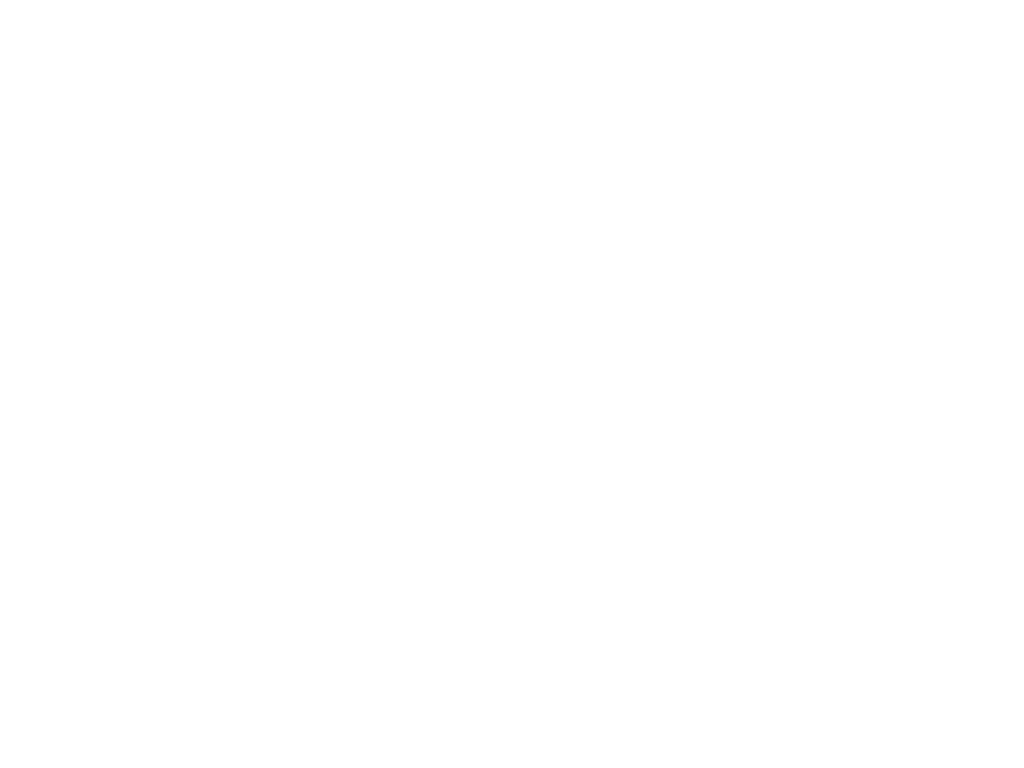

In [25]:
%matplotlib notebook
x = generate_points(30, -100, 100, -100, 100)
y = divide_and_conquer_visualisation(x)
p = Plot(scenes = y)
p.draw()

# Przyrostowy

In [26]:
from sortedcontainers import SortedList

def incremental(points):
    n = len(points)
    
    if n < 3:
        return None
    
    indexes = {}
    
    for i in range(n):
        indexes[points[i]] = i
    
    points = list(points)
    
    points.sort()
    
    hull = SortedList([(0, points[0])])
    
    if points[0][0] == points[1][0] and points[2][0] >= points[1][0]:
        hull.add((2 ** n, points[2]))
        hull.add((2 ** (n + 1), points[1]))
    else:
        direction = det(points[0], points[1], points[2])
        
        if direction > 0:
            hull.add((2 ** n, points[1]))
            hull.add((2 ** (n + 1), points[2]))
        else:
            hull.add((2 ** n, points[2]))
            hull.add((2 ** (n + 1), points[1]))
    
    for i in range(3, n):
        point = points[i]
        
        left_index = find_left_tangent(point, hull)
        right_index = find_right_tangent(point, hull)
        
        if right_index != 0:
            for i in range(right_index - 1, left_index, -1):
                hull.pop(i)
        else:
            for i in range(len(hull) - 1, left_index, -1):
                hull.pop(i)
        
        if left_index == len(hull) - 1:
            ind = (hull[left_index][0] + 2 ** n) * 2
        else:
            ind = (hull[left_index][0] + hull[left_index + 1][0]) // 2
        
        value = (ind, point)
        
        hull.add(value)
    
    result = [indexes[hull[i][1]] for i in range(len(hull))]
    
    return result

In [27]:
def find_left_tangent(point, hull):
    n = len(hull)
    
    left = 0
    right = n - 1
    
    result = -1
    
    while left <= right:
        mid = (left + right) // 2
        
        start_point = hull[left][1]
        start_next_point = hull[(left + 1) % n][1]
        
        end_point = hull[right][1]
        end_next_point = hull[(right + 1) % n][1]
        
        current_point = hull[(mid) % n][1]
        next_point = hull[(mid + 1) % n][1]
        
        d_left = det(point, start_point, start_next_point)
        d_mid = det(point, current_point, next_point)
        d_right = det(point, end_point, end_next_point)
        
        if d_mid <= 0:
            result = mid
            right = mid - 1
        else:
            if d_left <= 0:
                right = mid - 1
            elif d_right <= 0:
                left = mid + 1
            else:
                d = det(point, current_point, start_point)
                
                if d > 0:
                    right = mid - 1
                else:
                    left = mid + 1
    
    return result

In [28]:
def find_right_tangent(point, hull):
    n = len(hull)
    
    left = 0
    right = n - 1
    
    result = -1
    
    while left <= right:
        mid = (left + right) // 2
        
        start_point = hull[left][1]
        start_next_point = hull[(left + 1) % n][1]
        
        end_point = hull[right][1]
        end_next_point = hull[(right + 1) % n][1]
        
        current_point = hull[(mid) % n][1]
        next_point = hull[(mid + 1) % n][1]
        
        d_left = det(point, start_point, start_next_point)
        d_mid = det(point, current_point, next_point)
        d_right = det(point, end_point, end_next_point)
        
        if d_mid <= 0:
            result = mid
            left = mid + 1
        else:
            if d_left <= 0:
                right = mid - 1
            elif d_right <= 0:
                left = mid + 1
            else:
                d = det(point, current_point, start_point)
                
                if d > 0:
                    right = mid - 1
                else:
                    left = mid + 1
        
    return (result + 1) % n

In [29]:
def incremental_visualisation(points):
    n = len(points)
    
    if n < 3:
        return None
    
    scenes = []
    
    points = list(points)
    
    points.sort()
    
    hull = SortedList([(0, points[0])])
    
    if points[0][0] == points[1][0] and points[2][0] >= points[1][0]:
        hull.add((2 ** n, points[2]))
        hull.add((2 ** (n + 1), points[1]))
    else:
        direction = det(points[0], points[1], points[2])
        
        if direction > 0:
            hull.add((2 ** n, points[1]))
            hull.add((2 ** (n + 1), points[2]))
        else:
            hull.add((2 ** n, points[2]))
            hull.add((2 ** (n + 1), points[1]))
    
    for i in range(3, n):
        point = points[i]
        
        hull_points = [x[1] for x in hull]
        lines = convert_points_to_lines(hull_points)
        
        scenes.append(
            Scene(points=[PointsCollection(points, color="blue"), PointsCollection(hull_points, color="red"), PointsCollection([point], color="yellow")],
                 lines=[LinesCollection(lines, color="red")])
        )
        
        left_index = find_left_tangent(point, hull)
        right_index = find_right_tangent(point, hull)
        
        scenes.append(
            Scene(points=[PointsCollection(points, color="blue"), PointsCollection(hull_points, color="red"), PointsCollection([point], color="yellow")],
                 lines=[LinesCollection(lines, color="red"), LinesCollection([[point, hull_points[left_index]], [point, hull_points[right_index]]], color="yellow")])
        )
        
        if right_index != 0:
            for i in range(right_index - 1, left_index, -1):
                hull.pop(i)
        else:
            for i in range(len(hull) - 1, left_index, -1):
                hull.pop(i)
        
        if left_index == len(hull) - 1:
            ind = (hull[left_index][0] + 2 ** n) * 2
        else:
            ind = (hull[left_index][0] + hull[left_index + 1][0]) // 2
        
        value = (ind, point)
        
        hull.add(value)
    
    hull_points = [x[1] for x in hull]
    lines = convert_points_to_lines(hull_points)
    scenes.append(
            Scene(points=[PointsCollection(points, color="blue"), PointsCollection(hull_points, color="red")],
                 lines=[LinesCollection(lines, color="red")])
        )
    
    scenes.append(
        Scene(points=[PointsCollection(points, color="blue"), PointsCollection(hull_points, color="red")])
    )
    
    return scenes

<IPython.core.display.Javascript object>


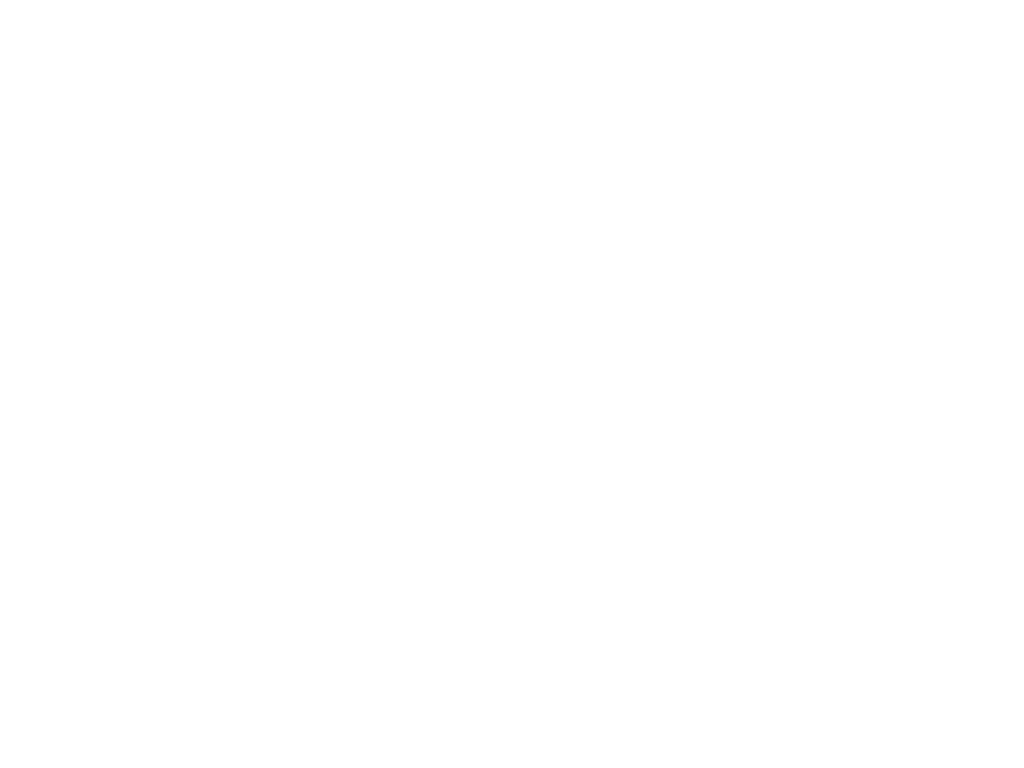

In [30]:
%matplotlib notebook
x = generate_points(30, -100, 100, -100, 100)
y = incremental_visualisation(x)
p = Plot(scenes = y)
p.draw()

In [31]:
# Quickhull

In [32]:
def line_point_distance(point, line_beginning, line_end):
    # the distance from a point to a line
    
    distance = 0
    
    x1 = line_beginning[0]
    y1 = line_beginning[1]
    
    x2 = line_end[0]
    y2 = line_end[1]
    
    x = point[0]
    y = point[1]
    
    delta_x = x2 - x1
    delta_y = y2 - y1
    
    if delta_x != 0 or delta_y != 0:
        distance = abs((delta_y * x - delta_x * y + x2 * y1 - y2 * x1) / (delta_x ** 2 + delta_y ** 2) ** (1/2))
    
    return distance

In [33]:
def part_quickhull(line_beginning, line_end, subset):
    # subset - set of point above or below line
    
    result = [] # part of the hull
    
    if not subset: return # empty subset
    if len(subset) == 1: return [subset[0]] # singleton
    
    max_point = max(subset, key=lambda x: line_point_distance(x, line_beginning, line_end))
    # the point farthest from the line
    
    up_subset = []
    down_subset = []
    
    for point in subset:
        if det(line_beginning, max_point, point) == -1:
            up_subset.append(point)
        if det(max_point, line_end, point) == -1:
            down_subset.append(point)
    
    up_part_hull = part_quickhull(line_beginning, max_point, up_subset)
    down_part_hull = part_quickhull(max_point, line_end, down_subset) # inverted orientation
    
    if up_part_hull: result.extend(up_part_hull)
    result.append(max_point)
    if down_part_hull: result.extend(down_part_hull)
            
    return result

In [34]:
def quickhull(points_set):
    hull = []
    
    sorted_set = sorted(points_set, key=lambda x: x[0])
    line_beginning = sorted_set[0] # the first point of hull
    line_end = sorted_set[-1] # the last point of the hull

    up_set = [] # subset of points above line
    down_set = [] # subset of points below line
    
    # divide the points above and below the line
    for point in points_set:
        if det(line_beginning, line_end, point) == -1:
            up_set.append(point)
        if det(line_beginning, line_end, point) == -1:
            down_set.append(point)
        # if orient == 0: do nothing, this point does not belong to the convex hull
    
    up_hull = part_quickhull(line_beginning, line_end, up_set)
    down_hull = part_quickhull(line_end, line_beginning, down_set) # inverted orientation
    
    hull.append(line_beginning) # the first point
    if up_hull: hull.extend(up_hull) # hull above line
    hull.append(line_end) # the last point
    if down_hull: hull.extend(down_hull) # hull below
        
    return hull

In [35]:
def part_quickhull_visualisation(points_set, line_beginning, line_end, subset, scenes, hull_points, hull_lines):
    # subset - set of point above or below line
    
    result = [] # part of the hull
    
    if not subset: return # empty subset
    if len(subset) == 1: 
        hull_points.append(subset[0])
        hull_lines.append([line_beginning, line_end])
        hull_lines.append([line_beginning, subset[0]])
        hull_lines.append([line_end, subset[0]])
        
        scenes.append(Scene(points = [PointsCollection(points_set.copy(), color="deepskyblue"),
                                      PointsCollection(hull_points.copy(), color="black"),
                                      PointsCollection([subset[0]], color="lime")],
                            lines = [LinesCollection(hull_lines.copy(), color="black"),
                                     LinesCollection([[line_beginning, line_end],
                                                      [line_beginning, subset[0]],
                                                      [line_end, subset[0]]],
                                                     color = "lime")]))

        return [subset[0]] # singleton
    
    max_point = max(subset, key=lambda x: line_point_distance(x, line_beginning, line_end))
    # the point farthest from the line
    
    hull_points.append(max_point)
    hull_lines.append([line_beginning, line_end])
    hull_lines.append([line_beginning, max_point])
    hull_lines.append([line_end, max_point])
    
    scenes.append(Scene(points = [PointsCollection(points_set.copy(), color="deepskyblue"),
                                  PointsCollection(hull_points.copy(), color="black"),
                                  PointsCollection([max_point], color="lime")],
                        lines = [LinesCollection(hull_lines.copy(), color="black"),
                                 LinesCollection([[line_beginning, line_end], 
                                                  [line_beginning, max_point],
                                                  [line_end, max_point]],
                                                 color = "lime")]))
    
    up_subset = []
    down_subset = []
    
    for point in subset:
        if det(line_beginning, max_point, point) == -1:
            up_subset.append(point)
        if det(max_point, line_end, point) == -1:
            down_subset.append(point)
    
    up_part_hull = part_quickhull_visualisation(points_set, line_beginning, max_point, up_subset, scenes, hull_points, hull_lines)
    down_part_hull = part_quickhull_visualisation(points_set, max_point, line_end, down_subset, scenes, hull_points, hull_lines) # inverted orientation
    
    if up_part_hull: result.extend(up_part_hull)
    result.append(max_point)
    if down_part_hull: result.extend(down_part_hull)
            
    return result

In [36]:
def quickhull_visualisation(points_set):
    scenes = []
    scenes.append(Scene(points = [PointsCollection(points_set.copy(),color="deepskyblue")]))
    
    sorted_set = sorted(points_set, key=lambda x: x[0])
    line_beginning = sorted_set[0] # the first point of hull
    line_end = sorted_set[-1] # the last point of the hull
    
    scenes.append(Scene(points = [PointsCollection(points_set.copy(),color="deepskyblue"),
                                  PointsCollection([line_beginning, line_end], color="black")],
                        lines = [LinesCollection([[line_beginning, line_end]], color="black")]))
    
    hull = [] # result hull
    hull.append(line_beginning)
    hull.append(line_end)
    
    hull_points = []
    hull_points.append(line_beginning)
    hull_points.append(line_end)
    
    hull_lines = []
    hull_lines.append([line_beginning, line_end])

    up_set = [] # subset of points above line
    down_set = [] # subset of points below line
    
    # divide the points above and below the line
    for point in points_set:
        if det(line_beginning, line_end, point) == -1:
            up_set.append(point)
        if det(line_beginning, line_end, point) == 1:
            down_set.append(point)
        # if orient == 0: do nothing, this point does not belong to the convex hull
    
    up_hull = part_quickhull_visualisation(points_set, line_beginning, line_end, up_set, scenes, hull_points, hull_lines)
    down_hull = part_quickhull_visualisation(points_set, line_end, line_beginning, down_set, scenes, hull_points, hull_lines) # inverted orientation
    
    hull.append(line_beginning) # the first point
    if up_hull: hull.extend(up_hull) # hull above line
    hull.append(line_end) # the last point
    if down_hull: hull.extend(down_hull) # hull below
        
    lines_of_hull = convert_points_to_lines(hull)[2:] # without the line from the beginning
    
    scenes.append(Scene(points = [PointsCollection(points_set.copy(), color="deepskyblue"),
                                  PointsCollection(hull.copy(), color="red")],
                        lines = [LinesCollection(lines_of_hull.copy(), color="red")]))
                      
    return scenes

<IPython.core.display.Javascript object>


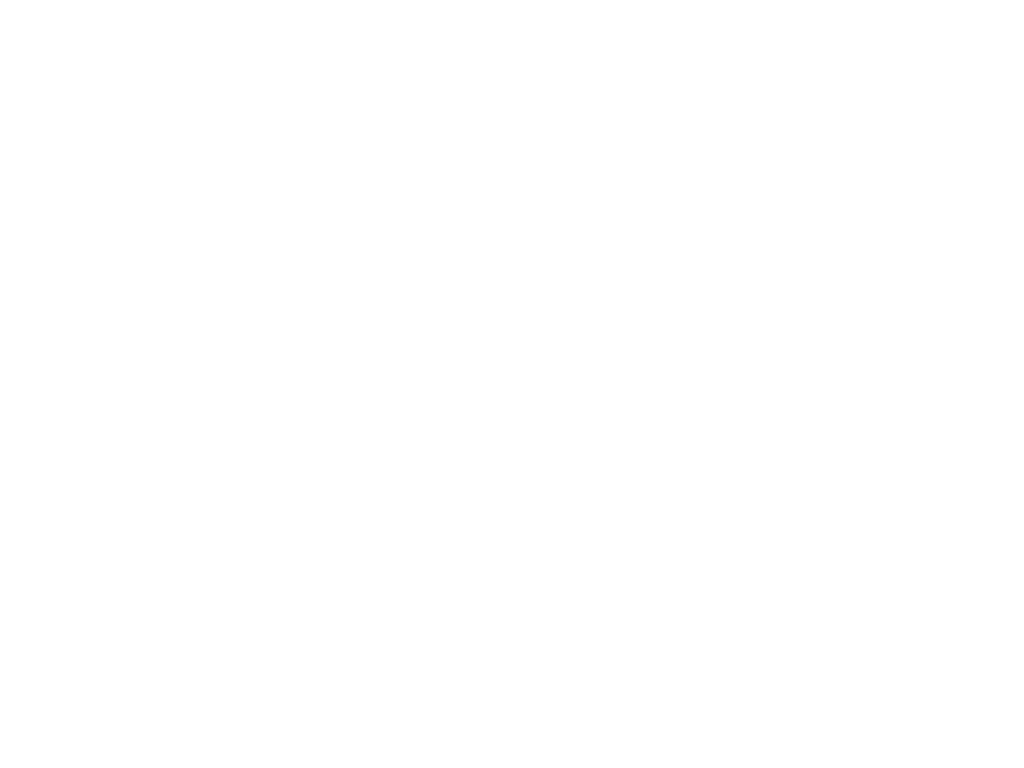

In [37]:
%matplotlib notebook
x = generate_points(100, -100, 100, -100, 100)
y = quickhull_visualisation(x)
p = Plot(scenes = y)
p.draw()

<IPython.core.display.Javascript object>


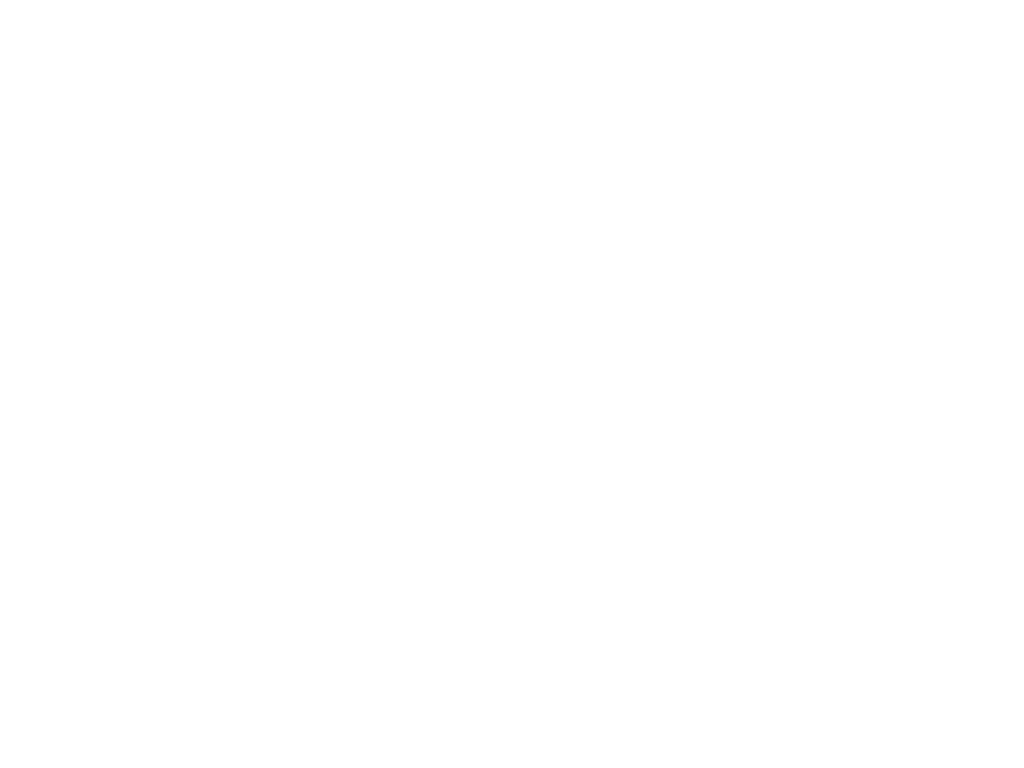

In [38]:
%matplotlib notebook
p = Plot(scenes = quickhull_visualisation(set_b))
p.draw()

# Górnej i dolnej otoczki

In [39]:
def upper_lower_hull(points_set):
    points = sorted(points_set, key=lambda x: (x[0], x[1]))
    points_length = len(points)
    
    # UPPER
    
    upper = []
    upper.append(points[0])
    upper.append(points[1])
    n = len(upper)
    
    for i in range(2, points_length):
        upper.append(points[i])
        n += 1
        
        while n > 2 and det(upper[-3], upper[-2], upper[-1]) >= 0:
            upper.pop(-2)
            n -= 1
    
    # LOWER
    
    lower = []
    lower.append(points[-1])
    lower.append(points[-2])
    n = len(lower)
    
    for i in range(points_length-3 , -1, -1):
        lower.append(points[i])
        n += 1
        
        while n > 2 and det(lower[-3], lower[-2], lower[-1]) >= 0:
            lower.pop(-2)
            n -= 1

    hull = upper + lower[1:]
    
    return hull

In [40]:
def upper_lower_hull_visualisation(points_set):
    points = sorted(points_set, key=lambda x: (x[0], x[1]))
    points_length = len(points)
    scenes = []
    hull_lines = []
    tmp_lines = []
    
    # UPPER
    
    upper = []
    upper_lines = []
    upper.append(points[0])
    upper.append(points[1])
    n = len(upper)
    upper_lines.append([points[0], points[1]])
    scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                  PointsCollection(upper.copy(), color="red")],
                        lines = [LinesCollection(upper_lines.copy(), color="red")]))
    
    for i in range(2, points_length):
        upper.append(points[i])
        n += 1       
        tmp_lines.append([upper[-2], upper[-1]])   
        scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                      PointsCollection(upper.copy(), color="red"),
                                      PointsCollection([upper[-1]], color="lime")],
                            lines = [LinesCollection(upper_lines.copy(), color="red"),
                                     LinesCollection(tmp_lines.copy(), color="lime")]))
        tmp_lines.pop()
                   
        while n > 2 and det(upper[-3], upper[-2], upper[-1]) >= 0:
            upper.pop(-2)
            n -= 1   
            upper_lines.pop()
            tmp_lines.append([upper[-2], upper[-1]])
            scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                          PointsCollection(upper.copy(), color="red"),
                                          PointsCollection([upper[-1]], color="lime")],
                                lines = [LinesCollection(upper_lines.copy(), color="red"),
                                         LinesCollection(tmp_lines.copy(), color="lime")]))
            tmp_lines.pop()
            
        upper_lines.append([upper[-2], upper[-1]])
        scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                      PointsCollection(upper.copy(), color="red"),
                                      PointsCollection([upper[-1]], color="lime")],
                            lines = [LinesCollection(upper_lines.copy(), color="red"),
                                     LinesCollection(tmp_lines.copy(), color="lime")]))
        
    # LOWER
    
    lower = []
    lower_lines = []
    lower.append(points[-1])
    lower.append(points[-2])
    n = len(lower)
    lower_lines.append([lower[-2], lower[-1]])
    
    for i in range(points_length-3 , -1, -1):
        lower.append(points[i])
        n += 1
        tmp_lines.append([lower[-2], lower[-1]])
        scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                      PointsCollection(upper.copy(), color="red"),
                                      PointsCollection(lower.copy(), color="blue"),
                                      PointsCollection([lower[-1]], color="lime")],
                            lines = [LinesCollection(upper_lines.copy(), color ="red"),
                                     LinesCollection(lower_lines.copy(), color ="blue"),
                                     LinesCollection(tmp_lines.copy(), color ="lime")]))
        tmp_lines.pop()
        
        while n > 2 and det(lower[-3], lower[-2], lower[-1]) >= 0:
            lower.pop(-2)
            n -= 1
            lower_lines.pop()
            tmp_lines.append([lower[-2], lower[-1]])
            scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                          PointsCollection(upper.copy(), color="red"),
                                          PointsCollection(lower.copy(), color="blue"),
                                          PointsCollection([lower[-1]], color="lime")],
                                lines = [LinesCollection(upper_lines.copy(), color="red"),
                                         LinesCollection(lower_lines.copy(), color="blue"),
                                         LinesCollection(tmp_lines.copy(), color="lime")]))
            tmp_lines.pop()
        
        lower_lines.append([lower[-2], lower[-1]])
        scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                      PointsCollection(upper.copy(), color="red"),
                                      PointsCollection(lower.copy(), color="blue"),
                                      PointsCollection([lower[-1]], color="lime")],
                            lines = [LinesCollection(upper_lines.copy(),color="red"),
                                     LinesCollection(lower_lines.copy(),color="blue"),
                                     LinesCollection(tmp_lines.copy(), color="lime")]))
            
    scenes.append(Scene(points = [PointsCollection(points.copy(), color="deepskyblue"),
                                  PointsCollection(upper.copy(), color="red"),
                                  PointsCollection(lower.copy(), color="blue")],
                        lines = [LinesCollection(upper_lines.copy(), color="red"),
                                 LinesCollection(lower_lines.copy(), color="blue")]))
        
    return scenes

<IPython.core.display.Javascript object>


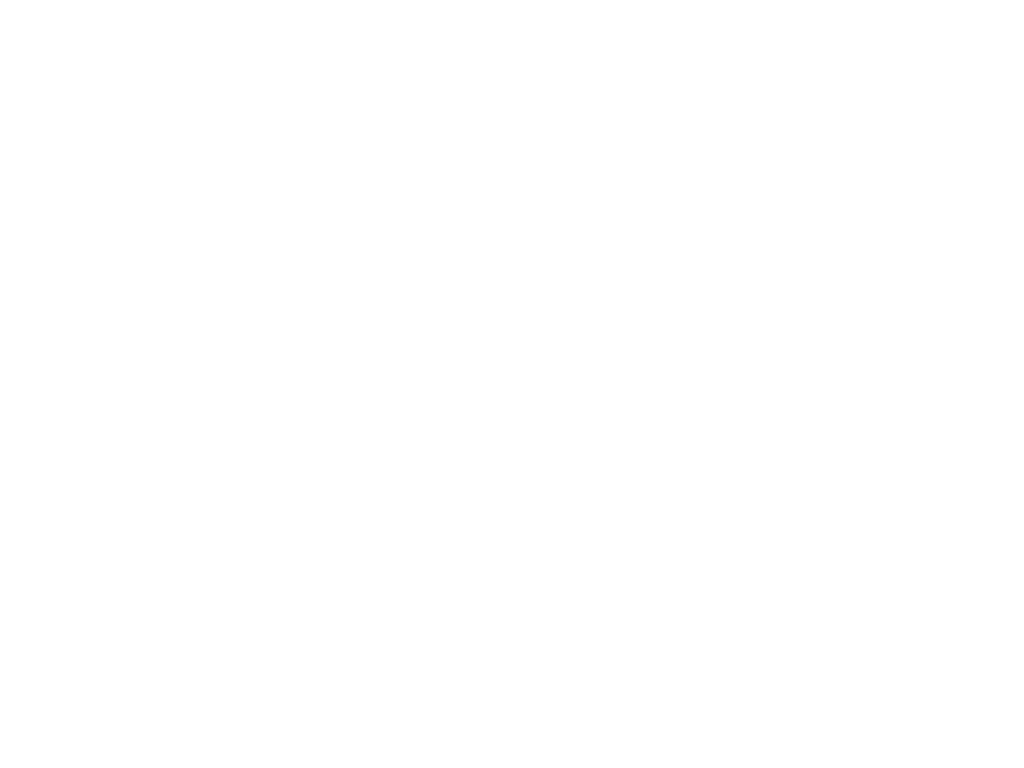

In [41]:
%matplotlib notebook
p = Plot(scenes = upper_lower_hull_visualisation(gen_set_d()))
p.draw()

# Algorytm Jarvisa

In [42]:
def jarvis(points): 
    hull = [] 
    
    start_point = min(points, key=lambda x: (x[1], x[0]))
    hull_point = start_point
    end_point = points[0]
    
    while True: 
        hull.append(hull_point) 
        end_point = points[0]
        
        for i in range(len(points)): 
            if (det(hull_point, end_point, points[i]) == 1) or det(hull_point, points[i], end_point) == 0 and distance(hull_point, points[i]) > distance(hull_point, end_point): 
                end_point = points[i] 

        hull_point = end_point 
  
        if hull_point == start_point: 
            break
            
    return hull

In [43]:
def jarvis_visualisation(points): 
    scenes = []
    hull = [] 
    
    start_point = min(points, key = lambda x: (x[1], x[0]))
    hull_point = start_point
    end_point = points[0]
    
    while True: 
        hull.append(hull_point) 
        end_point = points[0]
        
        for i in range(len(points)): 
            scenes.append(Scene([PointsCollection(points, color="deepskyblue"),
                                 PointsCollection(hull.copy(), color="red"), 
                                 PointsCollection([points[i]], color="green")],
                                [LinesCollection([(hull[i], hull[i+1]) for i in range(len(hull)-1)], color="red"),
                                 LinesCollection([(points[i], hull[-1])], color="green")])) 
            
            if (det(hull_point, end_point, points[i]) == 1) or det(hull_point, points[i], end_point) == 0 and distance(hull_point, points[i]) > distance(hull_point, end_point): 
                end_point = points[i] 

        hull_point = end_point 
  
        if hull_point == start_point: 
            break
            
    lines = [(hull[i], hull[i+1]) for i in range(len(hull)-1)]
    lines.append([hull[-1], hull[0]])
    
    scenes.append(Scene([PointsCollection(points, color="deepskyblue"),
                         PointsCollection(hull, color="red")],
                        [LinesCollection([(hull[i-1], hull[i]) for i in range(len(hull))], color="red")]))
  
    return scenes

<IPython.core.display.Javascript object>


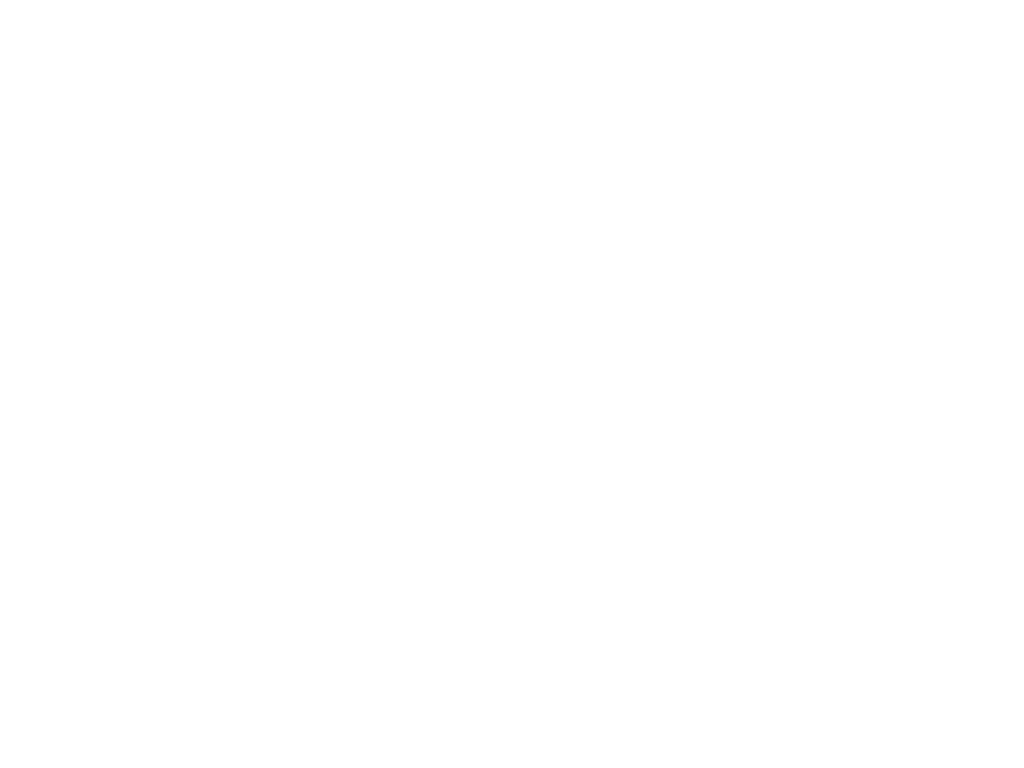

In [44]:
%matplotlib notebook
p = Plot(scenes = jarvis_visualisation(gen_set_d()))
p.draw()

# Algorytm Jarvisa

In [45]:
def jarvis(points): 
    hull = [] 
    
    start_point = min(points, key=lambda x: (x[1], x[0]))
    hull_point = start_point
    end_point = points[0]
    
    while True: 
        hull.append(hull_point) 
        end_point = points[0]
        
        for i in range(len(points)): 
            if (det(hull_point, end_point, points[i]) == 1) or det(hull_point, points[i], end_point) == 0 and distance(hull_point, points[i]) > distance(hull_point, end_point): 
                end_point = points[i] 

        hull_point = end_point 
  
        if hull_point == start_point: 
            break
            
    return hull

In [46]:
def jarvis_visualisation(points): 
    scenes = []
    hull = [] 
    
    start_point = min(points, key = lambda x: (x[1], x[0]))
    hull_point = start_point
    end_point = points[0]
    
    while True: 
        hull.append(hull_point) 
        end_point = points[0]
        
        for i in range(len(points)): 
            scenes.append(Scene([PointsCollection(points, color="deepskyblue"),
                                 PointsCollection(hull.copy(), color="red"), 
                                 PointsCollection([points[i]], color="green")],
                                [LinesCollection([(hull[i], hull[i+1]) for i in range(len(hull)-1)], color="red"),
                                 LinesCollection([(points[i], hull[-1])], color="green")])) 
            
            if (det(hull_point, end_point, points[i]) == 1) or det(hull_point, points[i], end_point) == 0 and distance(hull_point, points[i]) > distance(hull_point, end_point): 
                end_point = points[i] 

        hull_point = end_point 
  
        if hull_point == start_point: 
            break
            
    lines = [(hull[i], hull[i+1]) for i in range(len(hull)-1)]
    lines.append([hull[-1], hull[0]])
    
    scenes.append(Scene([PointsCollection(points, color="deepskyblue"),
                         PointsCollection(hull, color="red")],
                        [LinesCollection([(hull[i-1], hull[i]) for i in range(len(hull))], color="red")]))
  
    return scenes

<IPython.core.display.Javascript object>


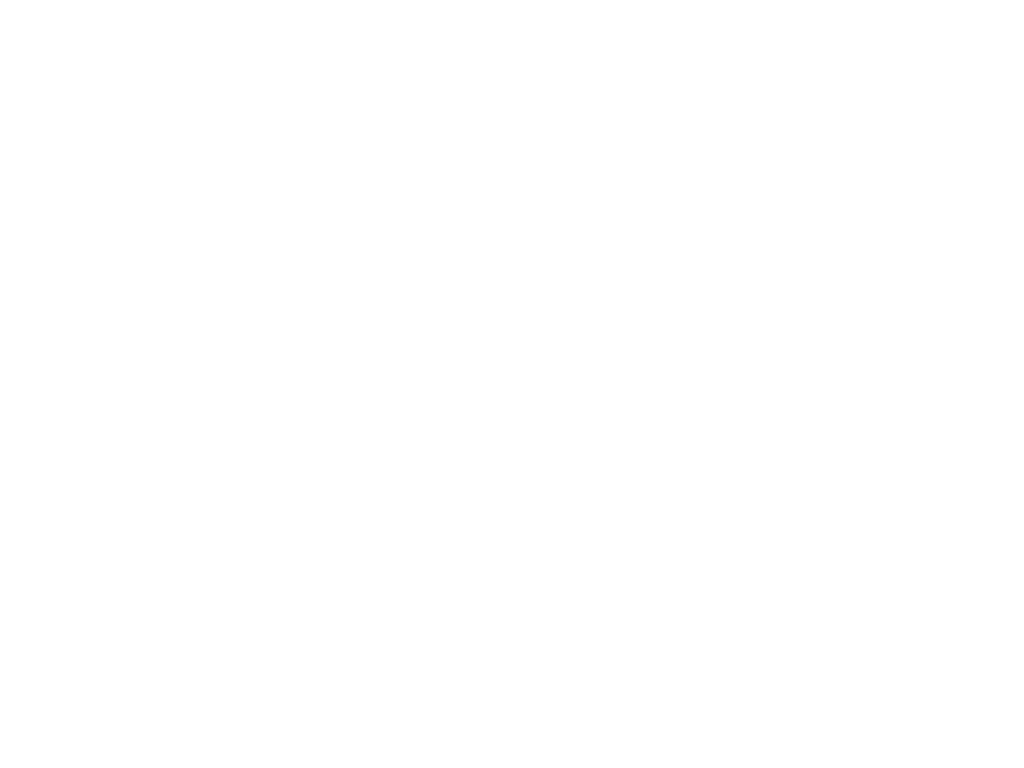

In [47]:
%matplotlib notebook
p = Plot(scenes = jarvis_visualisation(gen_set_d()))
p.draw()

# Algorytm Grahama

In [48]:
def find_minimum_point(points):
    point = points[0]
    
    for i in range(1, len(points)):
        if points[i] < point:
            point = points[i]
    
    return point

In [49]:
def find_maximum_point(points):
    point = points[0]
    
    for i in range(1, len(points)):
        if points[i] > point:
            point = points[i]
    
    return point

In [50]:
from functools import cmp_to_key

p = (0,0)
def compare(a, b):
    global p
    d = det(p, a, b)

    if d == 0:
        if distance(p, a) >= distance(p, b):
            return 1
        else:
            return -1
    elif d > 0:
        return -1
    else:
        return 1

In [51]:
def filter_points(points):
    result = []
    
    if are_collinear(points) and len(points) > 0:
        a = find_minimum_point(points)
        b = find_maximum_point(points)
        result.append(a)
        result.append(b)
    elif len(points) > 1:
        global p

        for i in range(len(points) - 1):
            if det(p, points[i], points[i+1]) != 0:
                result.append(points[i])

        if det(p, points[-2], points[-1]) == 0 and len(result) > 0:
            result.pop()
        result.append(points[-1])

    return result

In [52]:
def find_lowest(points):
    index = 0
    
    for i in range(1, len(points)):
        if points[i][1] < points[index][1] or (points[i][1] == points[index][1] and points[i][0] < points[index][0]):
            index = i
    
    return index

In [53]:
def graham(points):
    points = list(points)
    
    index = find_lowest(points)
    points[index], points[-1] = points[-1], points[index]
    
    global p
    p = points[-1]
    points.pop()
    
    points.sort(key=cmp_to_key(compare))
    points = filter_points(points)
    
    if len(points) < 3:
        points.insert(0, p)
        
        if are_collinear(points):
            result = []
            a = find_minimum_point(points)
            b = find_maximum_point(points)
            result.append(a)
            result.append(b)
            
            return result
        else:
            return points
    
    stack = [p, points[0], points[1]]

    for i in range(2, len(points)):
        while len(stack) > 1 and det(stack[-2], stack[-1], points[i]) != 1:
            stack.pop()
        stack.append(points[i])
    
    return stack

In [54]:
def make_segments(points):
    n = len(points)
    
    lines = []
    
    for i in range(n - 1):
        lines.append([points[i], points[i + 1]])
    
    return lines

In [55]:
def graham_visualisation(points):
    scenes = []

    input = list(points)
    points = list(points)
    
    index = find_lowest(points)
    points[index], points[-1] = points[-1], points[index]
    
    scenes.append(
        Scene(points=[PointsCollection(points.copy(), color="blue")])
    )
    
    global p
    p = points[-1]
    points.pop()
    
    points.sort(key=cmp_to_key(compare))
    points = filter_points(points)
    
    scenes.append(
        Scene(points=[PointsCollection(input.copy(), color="blue"), PointsCollection(points.copy(), color="orange")])
    )
    
    if len(points) < 3:
        points.insert(0, p)
        
        scenes.append(
            Scene(points=[PointsCollection(input.copy(), color="blue"), PointsCollection(points.copy(), color="red")],
                 lines = [LinesCollection(convert_points_to_lines(points), color="red")])
        )
        
        if are_collinear(points):
            result = []
            a = find_minimum_point(points)
            b = find_maximum_point(points)
            result.append(a)
            result.append(b)
            
            scenes.append(
            Scene(points=[PointsCollection(input.copy(), color="blue"), PointsCollection(result.copy(), color="red")],
                 lines = [LinesCollection(convert_points_to_lines(result), color="red")])
        )
        return scenes
    
    stack = [p, points[0], points[1]]

    for i in range(2, len(points)):
        scenes.append(
            Scene(points=[PointsCollection(input.copy(), color="blue"), PointsCollection(points.copy(), color="orange"), PointsCollection(stack.copy(), color="red")],
                 lines = [LinesCollection(make_segments(stack), color="red")])
        )
        while len(stack) > 1 and det(stack[-2], stack[-1], points[i]) != 1:
            stack.pop()
        stack.append(points[i])
    
    scenes.append(
            Scene(points=[PointsCollection(input.copy(), color="blue"), PointsCollection(stack.copy(), color="red")],
                 lines = [LinesCollection(convert_points_to_lines(stack), color="red")])
        )
    
    return scenes

In [56]:
# Algorytm Chana

In [57]:
def find_tangent(hull, point):
    n = len(hull)
    
    left = 0
    right = n - 1
    
    result = -1
    
    while left <= right:
        mid = (left + right) // 2
        
        start_point = hull[left]
        start_next_point = hull[(left + 1) % n]
        
        end_point = hull[right]
        end_next_point = hull[(right + 1) % n]
        
        current_point = hull[(mid) % n]
        next_point = hull[(mid + 1) % n]
        
        d_left = det(point, start_point, start_next_point)
        d_mid = det(point, current_point, next_point)
        d_right = det(point, end_point, end_next_point)
        
        if d_mid <= 0:
            result = mid
            left = mid + 1
        else:
            if d_left <= 0:
                right = mid - 1
            elif d_right <= 0:
                left = mid + 1
            else:
                d = det(point, current_point, start_point)
                
                if d > 0:
                    right = mid - 1
                else:
                    left = mid + 1
    
    if det(point, hull[result], hull[(result + 1) % n]) == 0 and distance(point, hull[result]) > distance(point, hull[(result + 1) % n]):
        return result
        
    return (result + 1) % n

In [58]:
def find_extreme_point(hulls):
    h = 0
    p = 0
    
    for i in range(len(hulls)):
        for j in range(len(hulls[i])):
            if hulls[i][j][1] < hulls[h][p][1]:
                h = i
                p = j
    
    return h, p

In [59]:
def find_next_point(hulls, coordinates):
    point = hulls[coordinates[0]][coordinates[1]]
    next = (coordinates[0], (coordinates[1] + 1) % len(hulls[coordinates[0]]))
    
    for h in range(len(hulls)):
        if h != coordinates[0]:
            tangent = find_tangent(hulls[h], point)
            
            q = hulls[next[0]][next[1]]
            r = hulls[h][tangent]
            
            d = det(point, q, r)
            
            if d == -1 or d == 0 and distance(point, r) > distance(point, q):
                next = (h, tangent)
    return next

In [60]:
import math

def partial_hull(points, m):
    n = len(points)
    
    r = math.ceil(n / m)
    
    hulls = []
    
    for i in range(r):
        hull = graham(points[i * m : min((i + 1) * m, n)])
        hulls.append(hull)
    
    hull = [find_extreme_point(hulls)]
    
    for i in range(m):
        next = find_next_point(hulls, hull[-1])
        
        if next == hull[0]:
            result = []
            for j in range(len(hull)):
                result.append((hulls[hull[j][0]][hull[j][1]]))
            return result
        hull.append(next)
    
    return None

In [61]:
def chan(points):
    n = len(points)
    
    if len(points) < 3:
        return None
    
    indexes = {}
    
    for i in range(n):
        indexes[points[i]] = i
    
    points = list(points)
    
    t = 1
    while True:
        m = min(2 ** (2 ** t), n)
        L = partial_hull(points, m)
        
        if L is not None:
            result = [indexes[L[i]] for i in range(len(L))]
            return result
        
        t += 1

In [62]:
import math

def partial_hull_visualisation(points, m, scenes):
    n = len(points)
    colors = ["green", "yellow", "darkblue", "brown", "purple", "black"]
    
    r = math.ceil(n / m)
    
    hulls = []
    
    p = [PointsCollection(points.copy(), color="blue")]
    lines = []
    
    for i in range(r):
        hull = graham(points[i * m : min((i + 1) * m, n)])
        hulls.append(hull)
        p.append(PointsCollection(hull.copy(), color=colors[i % len(colors)]))
        lines.append(LinesCollection(convert_points_to_lines(hull.copy()), color=colors[i % len(colors)]))
    
    scenes.append(
       Scene(points = p.copy(), lines = lines.copy())
    )
    
    hull = [find_extreme_point(hulls)]
    
    for i in range(m):
        next = find_next_point(hulls, hull[-1])
        res = [(hulls[hull[i][0]][hull[i][1]]) for i in range(len(hull))]
        lines.append(LinesCollection(make_segments(res.copy()), color="red"))
        scenes.append(
            Scene(points = p.copy(), lines = lines.copy())
        )
        
        if next == hull[0]:
            result = []
            for j in range(len(hull)):
                result.append((hulls[hull[j][0]][hull[j][1]]))
            return result
        hull.append(next)
    
    return None

In [63]:
def chan_visualisation(points):
    n = len(points)
    
    if len(points) < 3:
        return None
    
    points = list(points)
    
    scenes = []
    
    t = 1
    while True:
        m = min(2 ** (2 ** t), n)
        L = partial_hull_visualisation(points, m, scenes)
        
        if L is not None:
            scenes.append(
                Scene(points = [PointsCollection(points.copy(), color="blue"), PointsCollection(L, color="red")], lines = [LinesCollection(convert_points_to_lines(L), color="red")])
            )
            
            return scenes
        
        t += 1

# Działanie algorytmów

<IPython.core.display.Javascript object>


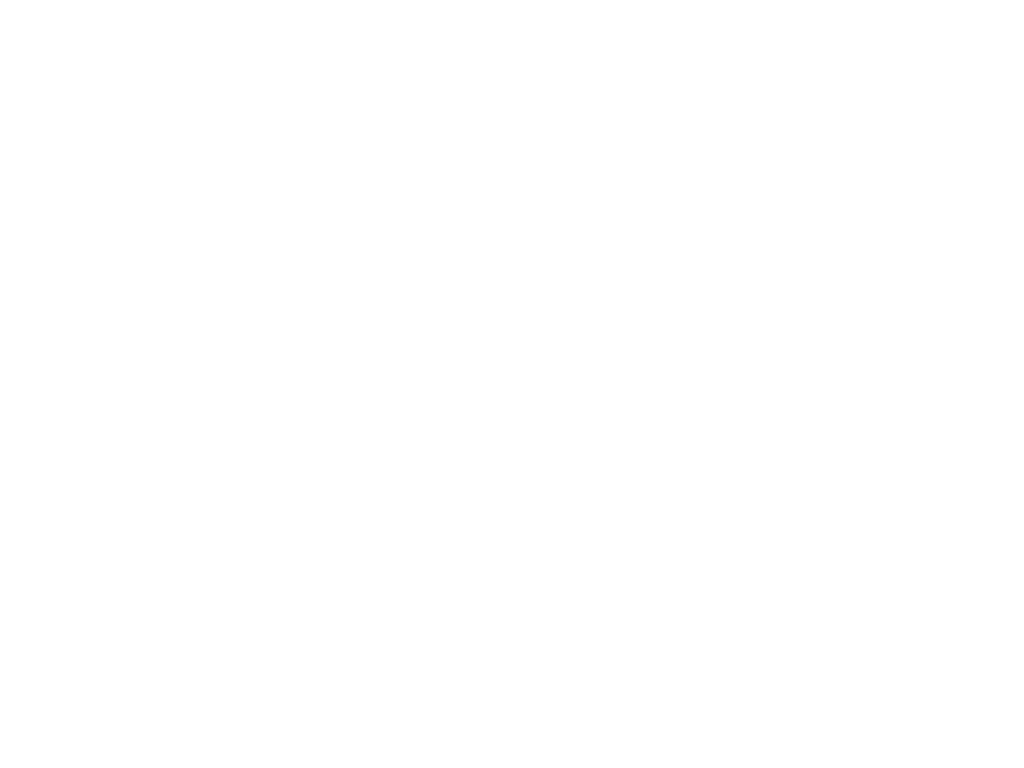

In [64]:
%matplotlib notebook
p = set_a
s = divide_and_conquer_visualisation(p)
plot = Plot(scenes = s)
plot.draw()

<IPython.core.display.Javascript object>


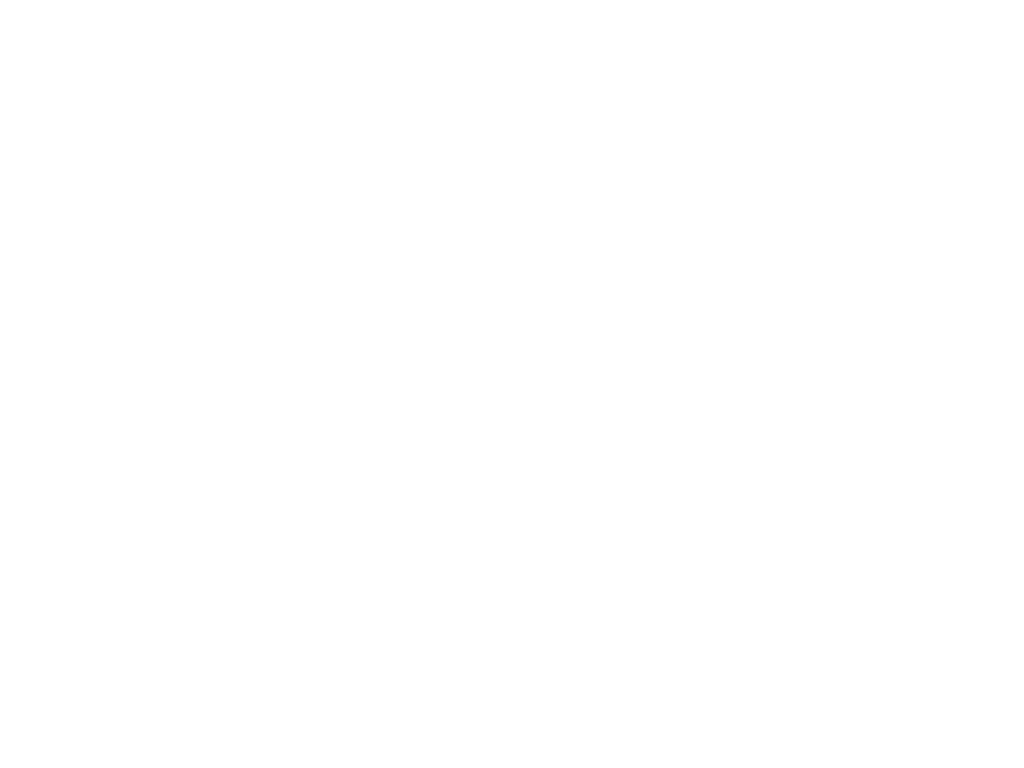

In [65]:
%matplotlib notebook
p = set_a
s = incremental_visualisation(p)
plot = Plot(scenes = s)
plot.draw()

<IPython.core.display.Javascript object>


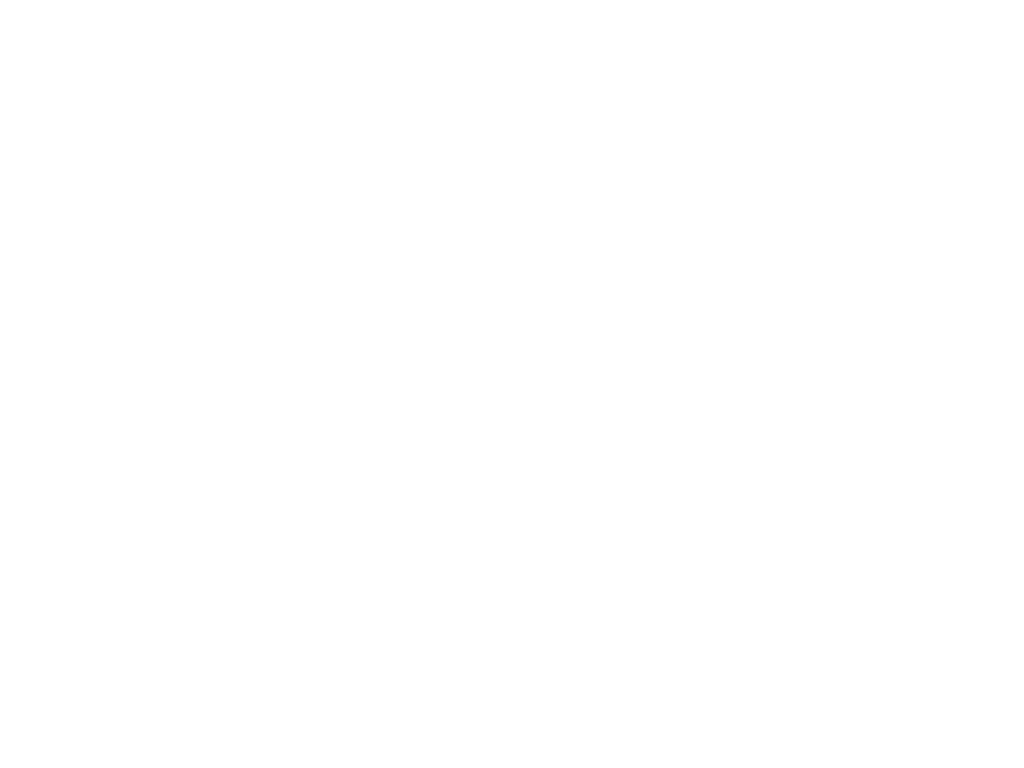

In [66]:
%matplotlib notebook
p = set_a
s = quickhull_visualisation(p)
plot = Plot(scenes = s)
plot.draw()

<IPython.core.display.Javascript object>


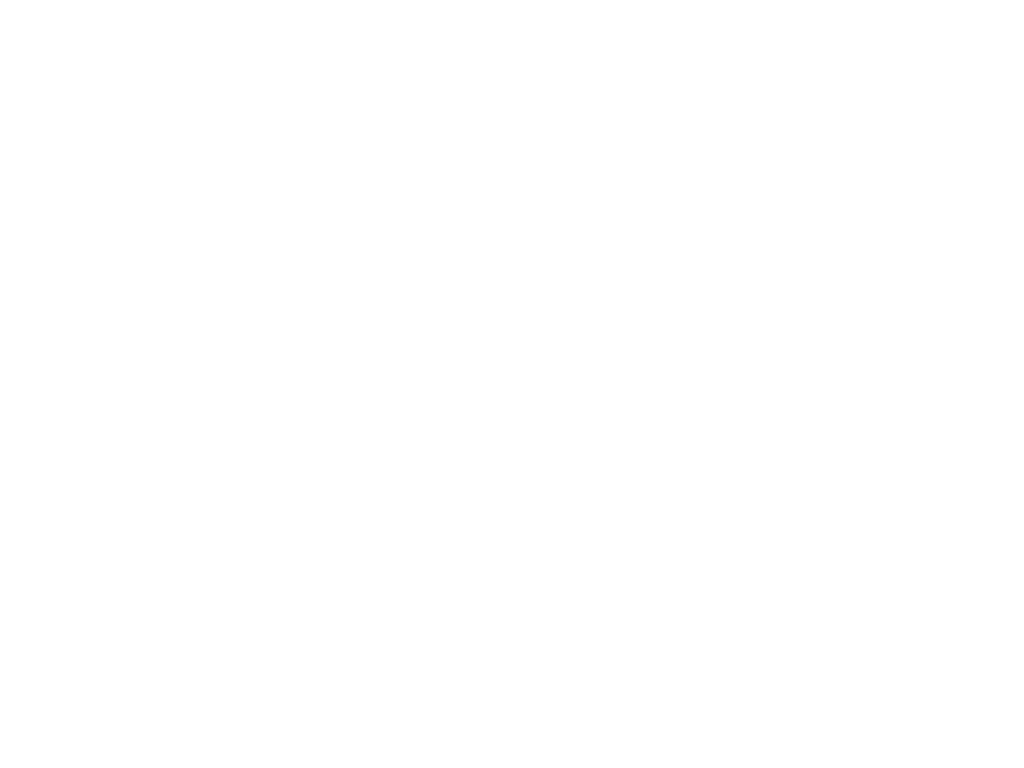

In [67]:
%matplotlib notebook
p = set_a
s = upper_lower_hull_visualisation(p)
plot = Plot(scenes = s)
plot.draw()

<IPython.core.display.Javascript object>


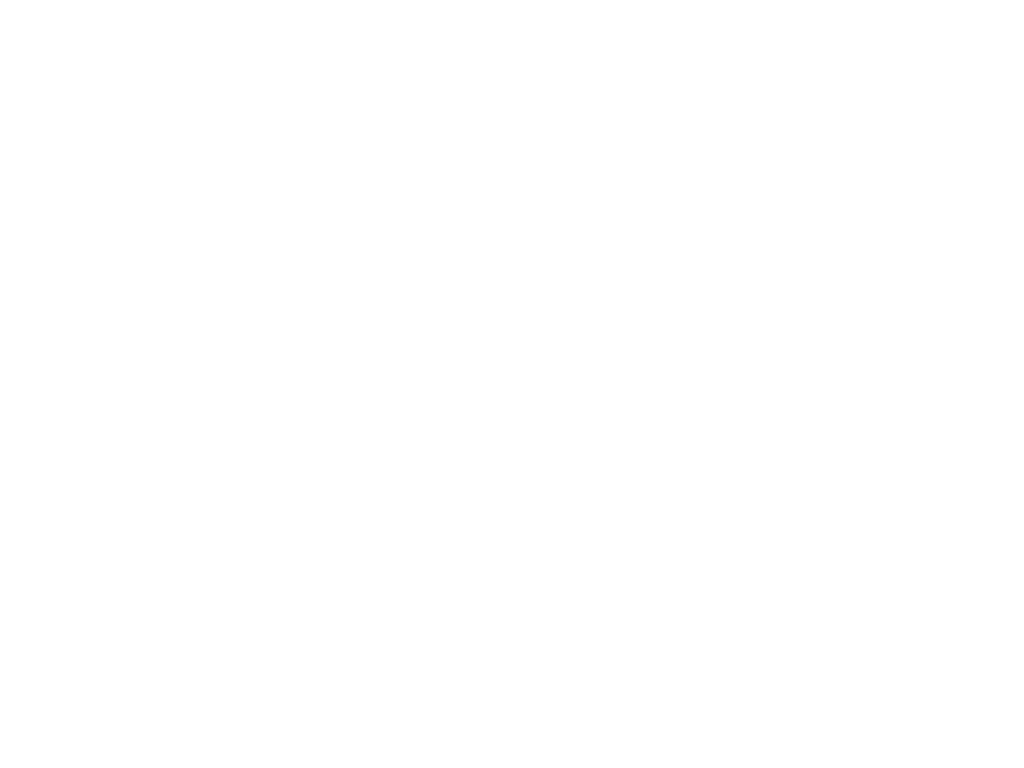

In [68]:
%matplotlib notebook
p = set_a
s = chan_visualisation(p)
plot = Plot(scenes = s)
plot.draw()

<IPython.core.display.Javascript object>


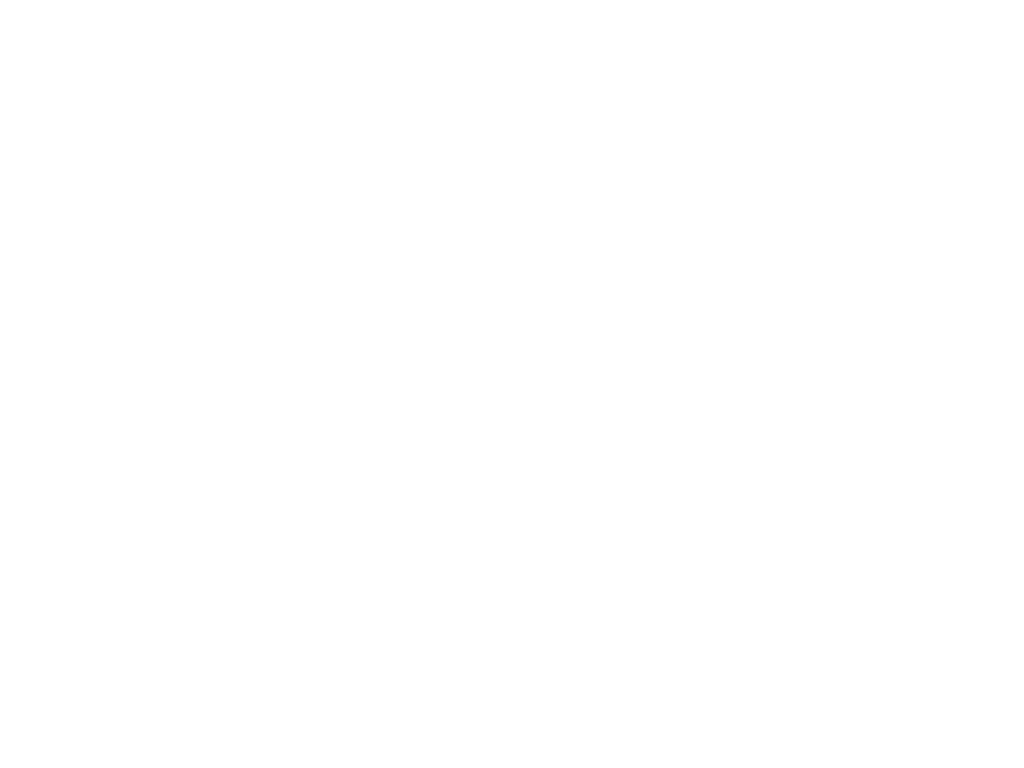

In [69]:
%matplotlib notebook
p = set_a
s = jarvis_visualisation(p)
plot = Plot(scenes = s)
plot.draw()

<IPython.core.display.Javascript object>


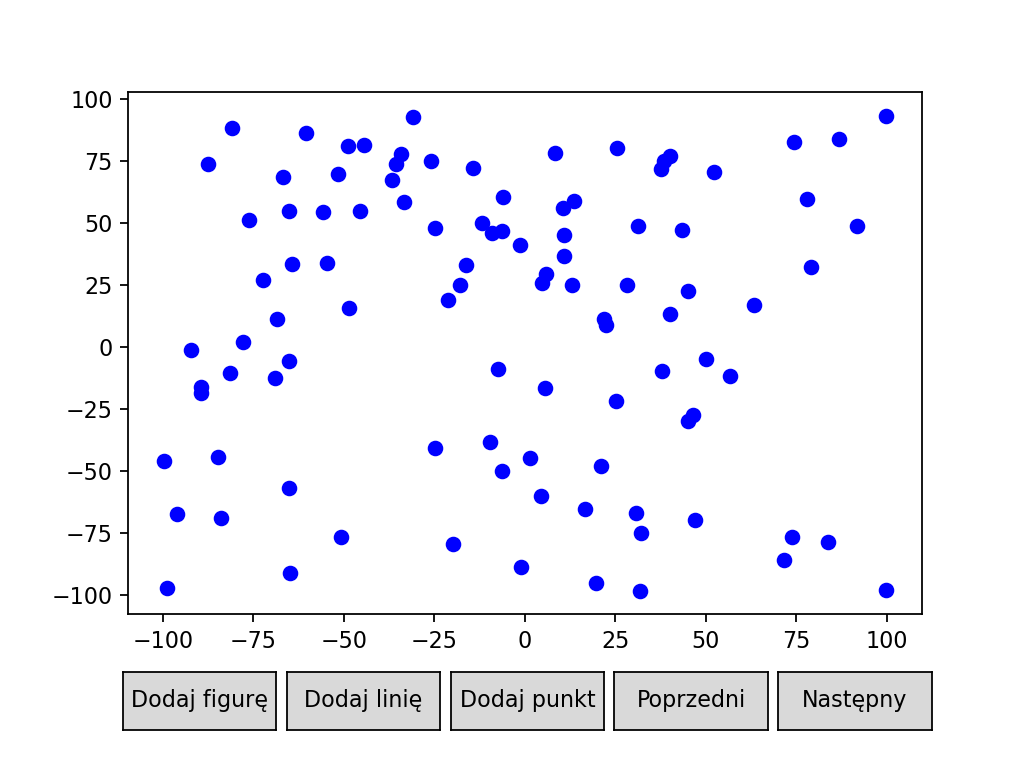

In [70]:
%matplotlib notebook
p = set_a
s = graham_visualisation(p)
plot = Plot(scenes = s)
plot.draw()

# Mierzenie czasów wykonania algorytmów

## 1

### Pierwszy zbiór

In [71]:
a = measure_time(divide_and_conquer, set_a)
b = measure_time(incremental, set_a)
c = measure_time(quickhull, set_a)
d = measure_time(upper_lower_hull, set_a)
e = measure_time(chan, set_a)
f = measure_time(jarvis, set_a)
g = measure_time(graham, set_a)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.004
0.007
0.0
0.001
0.003
0.001
0.001


### Drugi zbiór

In [72]:
a = measure_time(divide_and_conquer, set_b)
b = measure_time(incremental, set_b)
c = measure_time(quickhull, set_b)
d = measure_time(upper_lower_hull, set_b)
e = measure_time(chan, set_b)
f = measure_time(jarvis, set_b)
g = measure_time(graham, set_b)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.003
0.01
0.002
0.0
0.004
0.017
0.001


### Trzeci zbiór

In [73]:
a = measure_time(divide_and_conquer, set_c)
b = measure_time(incremental, set_c)
c = measure_time(quickhull, set_c)
d = measure_time(upper_lower_hull, set_c)
e = measure_time(chan, set_c)
f = measure_time(jarvis, set_c)
g = measure_time(graham, set_c)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.003
0.007
0.001
0.0
0.002
0.001
0.001


### Czwarty zbiór

In [74]:
a = measure_time(divide_and_conquer, set_d)
b = measure_time(incremental, set_d)
c = measure_time(quickhull, set_d)
d = measure_time(upper_lower_hull, set_d)
e = measure_time(chan, set_d)
f = measure_time(jarvis, set_d)
g = measure_time(graham, set_d)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.002
0.005
0.001
0.001
0.002
0.002
0.002


## 2

In [75]:
x = gen_set_a(A_NUM = 10**3)

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.017
0.067
0.005
0.004
0.028
0.02
0.009


In [76]:
x = gen_set_b(B_NUM = 10**3, B_RADIUS = 1000)

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.017
0.129
0.028
0.003
0.067
1.385
0.008


In [77]:
x = gen_set_c(10**3, (-1000, 1000), (-1000, -1000), (1000, -1000), (1000, 1000))

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.018
0.047
0.008
0.004
0.015
0.008
0.013


In [78]:
x = gen_set_d(10**3, 10**2, (0, 0), (1000, 0), (1000, 1000), (0, 1000))

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.06
0.076
0.014
0.009
0.032
0.019
0.048


## 3

In [79]:
x = gen_set_a(A_NUM = 10**4)

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.183
0.687
0.061
0.045
0.394
0.322
0.132


In [80]:
x = gen_set_b(B_NUM = 10**4, B_RADIUS = 1000)

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.219
3.531
0.31
0.035
0.779
145.843
0.113


In [81]:
x = gen_set_c(10**5, (-1000, 1000), (-1000, -1000), (1000, -1000), (1000, 1000))

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

1.286
16.628
0.866
0.548
1.436
0.771
2.239


In [82]:
x = gen_set_d(10**4, 10**3, (0, 0), (1000, 0), (1000, 1000), (0, 1000))

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

0.554
1.462
0.159
0.097
0.316
0.185
0.667


### Pierwszy zbiór - zwiększona liczba punktów

In [83]:
x = gen_set_a(A_NUM = 10**5)

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

1.398
11.833
0.953
0.533
3.89
4.408
1.68


### Drugi zbiór - zwiększona liczba punktów

In [84]:
x = gen_set_b(B_NUM = 10**5, B_RADIUS = 1000)

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
#f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
#print(f)
print(g)

1.968
72.584
4.781
0.571
14.681
1.555


### Trzeci zbiór - zwiększona liczba punktów

In [85]:
x = gen_set_c(10**5, (-1000, 1000), (-1000, -1000), (1000, -1000), (1000, 1000))

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

1.298
16.931
0.784
0.56
1.495
0.798
2.333


### Czwarty zbiór - zwiększona liczba punktów

In [86]:
x = gen_set_d(10**5, 10**3, (0, 0), (1000, 0), (1000, 1000), (0, 1000))

a = measure_time(divide_and_conquer, x)
b = measure_time(incremental, x)
c = measure_time(quickhull, x)
d = measure_time(upper_lower_hull, x)
e = measure_time(chan, x)
f = measure_time(jarvis, x)
g = measure_time(graham, x)
print(a)
print(b)
print(c)
print(d)
print(e)
print(f)
print(g)

2.93
97.176
1.326
1.016
3.061
1.657
8.186
